In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import pandas as pd
import datetime
from tqdm import tqdm_notebook
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1500)

In [ ]:
def read_data(path):
    df = pd.read_csv(path, sep=',', header=0)
    return df
def get_data():
    ## Read in the train and test data
    train_df = read_data("train.csv")
    features_df = read_data("features.csv")
    stores_df = read_data("stores.csv")
    train_df = train_df.merge(stores_df, how='left').merge(features_df, how='left')
    train_df["Split"] = ["Train"]*len(train_df)
    test_df = read_data("test.csv")
    test_df = test_df.merge(stores_df, how='left').merge(features_df, how='left')
    test_df["Split"] = ["Test"]*len(test_df)
    # Combine both train and test dataframes to make processing easier
    full_df = pd.concat((train_df, test_df), axis=0)
    return full_df



c:\users\nitin\anaconda3\envs\mouse_tracking\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [ ]:
def scale_columns(df, columns):
    for col in columns:
        df[col] = (df[col] - df[col].min()) / (df[col].max()-df[col].min())
    return df
def form_train_test_sets(df):
    y_train = df[df["Split"] == "Train"]["Weekly_Sales"]
    y_test = df[df["Split"] == "Test"]["Weekly_Sales"]
    X_train = df[df["Split"] == "Train"]
    X_test = df[df["Split"] == "Test"]
    X_train = X_train.drop(columns=["Split", "Date", "Store", "Dept", "Store_Dept"])
    X_test = X_test.drop(columns=["Split"])
    return X_train, X_test, y_train, y_test
def one_hot_encode(df, columns):
    df = pd.get_dummies(df, columns=columns)
    return df
def form_train_validation_sets(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_valid, y_train, y_valid

def process_data(df):
    # Convert date field to datetime field
    df["Date"] = pd.to_datetime(pd.to_datetime(df["Date"]), format='%Y-%m-%d')
    dates = df["Date"].astype(str).tolist()
    dates = [date.split("-") for date in dates]
    df["Year"], df["Month"], df["DayOfMonth"] = zip(*dates)
    df["WeekOfYear"] = [a.isocalendar()[1] for a in df["Date"]]
    df["WeekOfMonth"] = df["WeekOfYear"].apply(lambda x: x%4+1)
    df["Year"] = df["Year"].astype(int)
    df["Month"] = df["Month"].astype(int)
    df[["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]] = df[["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]].fillna(0.0) 
    
    ## Fill in negative values with zero
    df[df["MarkDown1"] < 0]["MarkDown1"] = 0
    df[df["MarkDown2"] < 0]["MarkDown2"] = 0
    df[df["MarkDown3"] < 0]["MarkDown3"] = 0
    df[df["MarkDown4"] < 0]["MarkDown4"] = 0
    df[df["MarkDown5"] < 0]["MarkDown5"] = 0
    df[df["Weekly_Sales"] < 0]["Weekly_Sales"] = 0
    df[df["Unemployment"] < 0]["Unemployment"] = 0
    df[df["CPI"] < 0]["CPI"] = 0
    df[df["Fuel_Price"]< 0]["Fuel_Price"]  = 0
    df[df["Size"] < 0]["Size"] = 0
    
    # Create new variables for holidays

    df["LaborDay"] = np.where((df["Date"] == datetime.datetime(2010, 9, 10)) | 
                                    (df["Date"] == datetime.datetime(2011, 9, 9)) |
                                    (df["Date"] == datetime.datetime(2012, 9, 7)) |
                                    (df["Date"] == datetime.datetime(2013, 9, 6)), True, False)

    df["Thanksgiving"] = np.where((df["Date"] == datetime.datetime(2010, 11, 26)) | 
                                    (df["Date"] == datetime.datetime(2011, 11, 25)) |
                                    (df["Date"] == datetime.datetime(2012, 11, 23)) |
                                    (df["Date"] == datetime.datetime(2013, 11, 29)), True, False)

    df["Christmas"] = np.where((df["Date"] == datetime.datetime(2010, 12, 31)) | 
                                    (df["Date"] == datetime.datetime(2011, 12, 30)) |
                                    (df["Date"] == datetime.datetime(2012, 12, 28)) |
                                    (df["Date"] == datetime.datetime(2013, 12, 27)), True, False)

    df["SuperBowl"] = np.where((df["Date"] == datetime.datetime(2010, 2, 12)) | 
                                    (df["Date"] == datetime.datetime(2011, 2, 11)) |
                                    (df["Date"] == datetime.datetime(2012, 2, 10)) |
                                    (df["Date"] == datetime.datetime(2013, 2, 8)), True, False)

    df["Store_Dept"] = df["Store"].astype(str) + "_" + df["Dept"].astype(str)
    
    store_dept_sales_medians = df[["Store_Dept", "Weekly_Sales","Date"]].groupby(["Store_Dept"]).median()
    store_dept_sales_medians = store_dept_sales_medians.to_dict()["Weekly_Sales"]
    
    new_df = pd.DataFrame()
    for sd in tqdm_notebook(set(df["Store_Dept"])):
        data = df[df["Store_Dept"] == sd].sort_values("Date")
        data['Previous_Year_Sales'] = data.groupby([data['Date'].dt.month,data['Date'].dt.week])['Weekly_Sales'].shift()
        data['Previous_2Year_Sales'] = data.groupby([data['Date'].dt.month,data['Date'].dt.week])['Weekly_Sales'].shift(2)
        data['Previous_3Year_Sales'] = data.groupby([data['Date'].dt.month,data['Date'].dt.week])['Weekly_Sales'].shift(3)
        data['Previous_Week_Sales'] = data.groupby([data['Date'].dt.month])['Weekly_Sales'].shift()
        data['Previous_2Week_Sales'] = data.groupby([data['Date'].dt.month])['Weekly_Sales'].shift(2)
        data['Previous_3Week_Sales'] = data.groupby([data['Date'].dt.month])['Weekly_Sales'].shift(3)
        impute_val = store_dept_sales_medians[sd]
        data[["Weekly_Sales", "Previous_Week_Sales",
             "Previous_2Week_Sales", "Previous_3Week_Sales",
             "Previous_Year_Sales", "Previous_2Year_Sales", 
             "Previous_3Year_Sales"]] =     data[["Weekly_Sales", "Previous_Week_Sales",
                                             "Previous_2Week_Sales", "Previous_3Week_Sales",
                                             "Previous_Year_Sales", "Previous_2Year_Sales", 
                                             "Previous_3Year_Sales"]].fillna(impute_val)


        new_df = pd.concat((new_df, data), axis=0)
    
    new_df[["CPI", "Unemployment"]] = new_df[["CPI", "Unemployment"]].fillna(0.0)
    df = new_df.drop(columns=["WeekOfYear", "DayOfMonth", "Year"])
    

    df = one_hot_encode(df, columns=["WeekOfMonth", "Type", "IsHoliday", "Month",
                                     "LaborDay", "Thanksgiving", "Christmas", "SuperBowl"])
    

    continuous_columns = ["Size", "Temperature", "Fuel_Price", "Unemployment", "CPI"] +\
                         ["MarkDown{}".format(i) for i in range(1,6)] +\
                         ["Previous_Year_Sales", "Previous_2Year_Sales", "Previous_3Year_Sales",
                          "Previous_Week_Sales", "Previous_2Week_Sales", "Previous_3Week_Sales"]
    df = scale_columns(df, continuous_columns)
    
    df = df.drop(columns=["LaborDay_False", "Thanksgiving_False", "Christmas_False", "SuperBowl_False", "IsHoliday_False"])
    df = df.fillna(0)
    
    return df

if not os.path.exists("train_processed_ml_models_data.csv"):
    full_df = get_data()
    full_df = process_data(full_df)
    full_df.to_csv("train_processed_ml_models_data.csv", index=False)
else:
    full_df = pd.read_csv("train_processed_ml_models_data.csv")
    

In [ ]:
X_train, X_test, y_train, y_test = form_train_test_sets(full_df)
X_train, X_valid, y_train, y_valid = form_train_validation_sets(X_train, y_train)
X_train = X_train.drop(columns=["Weekly_Sales"])
X_valid = X_valid.drop(columns=["Weekly_Sales"])
X_test = X_test.drop(columns=["Weekly_Sales"])

<IPython.core.display.Javascript object>


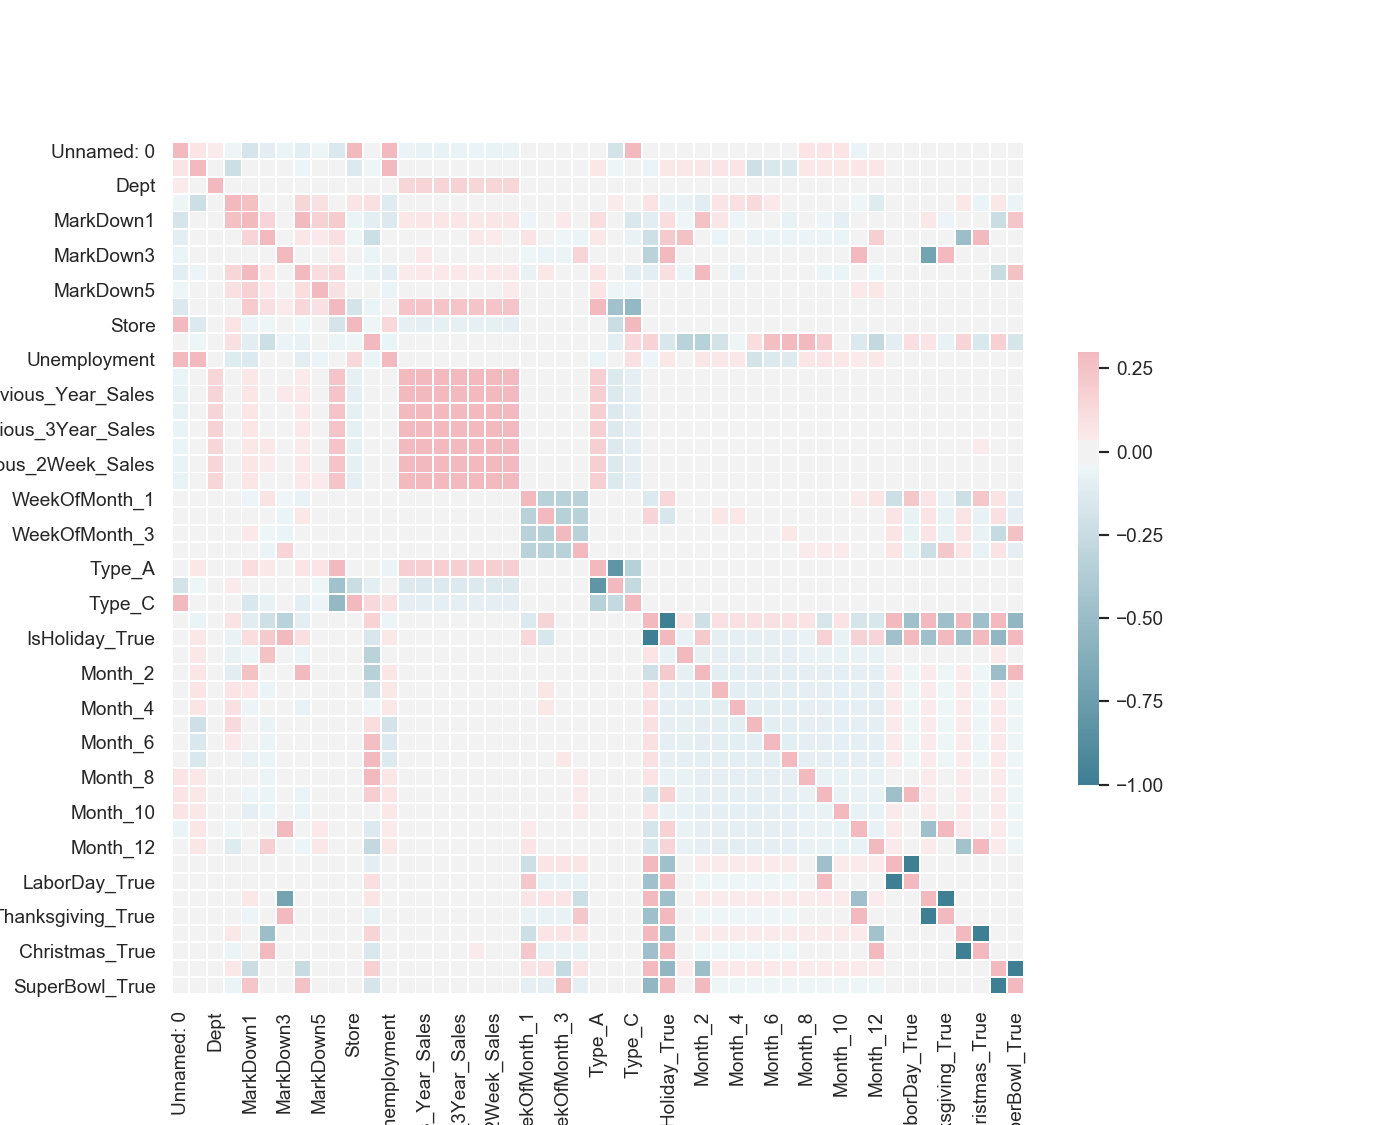

In [ ]:
# Code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html

def visualize_corr_mat(df):
    import seaborn as sns
    %matplotlib notebook
    sns.set(style="white")
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
visualize_corr_mat(full_df)

In [ ]:
def build_model(type="LR"):
    if type == "LR":
        regr = LinearRegression()
    elif type == "RF":
        regr = RandomForestRegressor(max_depth=40, random_state=0,
                              n_estimators=100, verbose=2, n_jobs=4)
    return regr

def calc_mae(y_pred, y_gt, weights):
    diffs = np.multiply(np.abs(np.array(y_pred) - np.array(y_gt)), np.array(weights))
    mae = sum(diffs)/np.sum(weights)
    return mae

'\nregr = build_model("RF")\nregr.fit(X_train, y_train)  \ny_pred = regr.predict(X_valid)\nimportant_features = list(zip(X_train.columns, regr.feature_importances_))\nimportant_features.sort(key = lambda x:x[1], reverse=True)\nprint(important_features)\nweights = np.where(X_valid["IsHoliday_True"] == 1, 5, 1)\ncalc_mae(y_pred, y_valid, weights)\n'

In [ ]:
# Number of trees in random forest
n_estimators = [100, 200, 300]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20, 40]
max_depth.append(None)

best_rf_model = None
min_mae = float("inf")
count = 1
for n_est in n_estimators:
    for max_feats in max_features:
        for depth in max_depth:
            regr = RandomForestRegressor(n_estimators=n_est, max_features=max_feats, max_depth=depth, 
                                         random_state=0, verbose=1, n_jobs=4)
            regr.fit(X_train, y_train) 
            y_pred = regr.predict(X_valid)
            ##important_features = list(zip(X_train.columns, regr.feature_importances_))
            ##important_features.sort(key = lambda x:x[1], reverse=True)
            ##print(important_features)
            weights = np.where(X_valid["IsHoliday_True"] == 1, 5, 1)
            mae = calc_mae(y_pred, y_valid, weights)
            print("RF Model #{} - (n_estimators:{}, max_features:{}, max_depth:{}) - MAE:{}".format(
                    count, n_est, max_feats, depth, mae))
            if mae < min_mae:
                min_mae = mae
                best_rf_model = regr
            count += 1


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


RF Model #1 - (n_estimators:100, max_features:auto, max_depth:20) - MAE:1740.6033234760253


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  4.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


RF Model #2 - (n_estimators:100, max_features:auto, max_depth:40) - MAE:1734.617307012192


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  5.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


RF Model #3 - (n_estimators:100, max_features:auto, max_depth:None) - MAE:1730.6766770792512


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   33.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


RF Model #4 - (n_estimators:100, max_features:sqrt, max_depth:20) - MAE:1756.02191037076


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   49.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


RF Model #5 - (n_estimators:100, max_features:sqrt, max_depth:40) - MAE:1736.3512135134154


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   45.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.5s finished


RF Model #6 - (n_estimators:100, max_features:sqrt, max_depth:None) - MAE:1731.4335970165935


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  5.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.3s finished


RF Model #7 - (n_estimators:200, max_features:auto, max_depth:20) - MAE:1737.6745420167415


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  7.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  7.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.3s finished


RF Model #8 - (n_estimators:200, max_features:auto, max_depth:40) - MAE:1727.2845129282089


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  7.2min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  7.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.3s finished


RF Model #9 - (n_estimators:200, max_features:auto, max_depth:None) - MAE:1726.1173123294027


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.0s finished


RF Model #10 - (n_estimators:200, max_features:sqrt, max_depth:20) - MAE:1753.590051435577


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.9s finished


RF Model #11 - (n_estimators:200, max_features:sqrt, max_depth:40) - MAE:1724.5152955415772


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.9s finished


RF Model #12 - (n_estimators:200, max_features:sqrt, max_depth:None) - MAE:1722.4528319699218


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 10.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.1s finished


RF Model #13 - (n_estimators:300, max_features:auto, max_depth:20) - MAE:1736.6224432983872


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 14.9min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 22.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    9.5s finished


RF Model #14 - (n_estimators:300, max_features:auto, max_depth:40) - MAE:1724.4878139382383


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 13.6min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 21.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    9.3s finished


RF Model #15 - (n_estimators:300, max_features:auto, max_depth:None) - MAE:1724.5053506769714


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   26.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  2.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.2s finished


RF Model #16 - (n_estimators:300, max_features:sqrt, max_depth:20) - MAE:1750.4584000834197


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   36.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.5s finished


RF Model #17 - (n_estimators:300, max_features:sqrt, max_depth:40) - MAE:1722.5882297815037


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   34.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.3s finished


RF Model #18 - (n_estimators:300, max_features:sqrt, max_depth:None) - MAE:1717.0061037052974


'\n# Minimum number of samples required to split a node\nmin_samples_split = [2, 5, 10]\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 4]\n# Method of selecting samples for training each tree\nbootstrap = [True, False]\n'

In [ ]:
X_test.shape, X_train.shape

((115064, 44), (337256, 40))

In [ ]:

X_test.head(2)

,CPI,Date,Dept,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Store,Temperature,Unemployment,Store_Dept,Previous_Year_Sales,Previous_2Year_Sales,Previous_3Year_Sales,Previous_Week_Sales,Previous_2Week_Sales,Previous_3Week_Sales,WeekOfMonth_1,WeekOfMonth_2,WeekOfMonth_3,WeekOfMonth_4,Type_A,Type_B,Type_C,IsHoliday_True,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,LaborDay_True,Thanksgiving_True,Christmas_True,SuperBowl_True
152,0.839767,2012-11-02,31,0.658818,0.130706,0.068747,0.001516,0.117469,0.002005,0.451136,45,0.546869,0.605533,45_31,0.011992,0.011281,0.007975,0.011588,0.010686,0.010793,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
153,0.839671,2012-11-09,31,0.650802,0.050835,0.126993,0.001317,0.009490,0.002854,0.451136,45,0.443885,0.605533,45_31,0.010793,0.011981,0.007975,0.010301,0.011588,0.010686,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Save model
import pickle
pickle.dump(file=open("model.pkl", "wb"), obj=regr)


In [ ]:

def make_submission(regr, X_test):
    test_features = X_test[['CPI','Fuel_Price', 'MarkDown1', 
                        'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 
                        'Size', 'Temperature', 'Unemployment', 
                        'Previous_Year_Sales', 'Previous_2Year_Sales', 
                        'Previous_3Year_Sales', 'Previous_Week_Sales', 'Previous_2Week_Sales', 
                        'Previous_3Week_Sales', 'WeekOfMonth_1', 'WeekOfMonth_2', 
                        'WeekOfMonth_3', 'WeekOfMonth_4', 'Type_A', 'Type_B', 'Type_C', 
                        'IsHoliday_True', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 
                        'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 
                        'Month_11', 'Month_12', 'LaborDay_True', 'Thanksgiving_True', 
                        'Christmas_True', 'SuperBowl_True']]
    test_features = test_features.fillna(0)
    y_test_pred = regr.predict(test_features)
    result_df = pd.DataFrame(data={"Store":X_test["Store"], "Dept":X_test["Dept"] , "Date":X_test["Date"], "Weekly_Sales":y_test_pred})
    result_df = result_df.sort_values(["Store", "Dept", "Date"])
    result_df["Id"] = result_df["Store"].astype(str) + "_" + result_df["Dept"].astype(str) + "_" + result_df["Date"].astype(str)
    result_df = result_df.drop(columns=["Store", "Dept", "Date"])
    result_df = result_df[["Id", "Weekly_Sales"]]
    result_df.to_csv("output.csv", index=False)
    print("output.csv created.")
make_submission(best_rf_model, X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.7s finished


output.csv created.
